In [1]:
from training_functions import *
from merging import *
from utils import *
from model_evaluation import ModelEvaluation
import pandas as pd

2024-10-17 15:03:09.091046: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-10-17 15:03:10.414493: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
def join_data_and_preds_exp(
    df_preds_full_mp: pd.DataFrame,
    df_data_exp_mp: pd.DataFrame,
) -> pd.DataFrame:
    df_preds_mp_exp = df_preds_full_mp.set_index("material_id").loc[df_data_exp_mp["mp"]].reset_index().copy()
    df_preds_mp_exp[["sigma_S_cm", "Ea", "icsd"]] = df_data_exp_mp[["σ(RT)(S cm-1)", "Ea (eV)", "icsd"]]
    df_preds_mp_exp = df_preds_mp_exp.join(
        1.0 / df_preds_mp_exp.groupby("material_id").size().rename("sample_weight"),
        on="material_id",
    )
    return df_preds_mp_exp


In [18]:
def join_data_and_preds_icsd(
    df_preds_icsd: pd.DataFrame,
    df_data_exp_full: pd.DataFrame,
) -> pd.DataFrame:
    data_icsd = df_data_exp_full.query("~`ICSD Entry`.isna()").reset_index(drop=True)
    data_icsd["ICSD Entry"] = data_icsd["ICSD Entry"].astype(int)
    data_icsd = data_icsd[["ICSD Entry", "σ(RT)(S cm-1)", "Ea (eV)"]].set_index("ICSD Entry")
    data_icsd.columns = ["sigma_S_cm", "Ea"]

    assert df_preds_icsd.groupby(["icsd"])["icdd_pdf"].apply(lambda x: len(x.unique()) == 1).all()
    df_preds_icsd = df_preds_icsd.join(
        1.0 / df_preds_icsd.groupby("icsd").size().rename("sample_weight"),
        on="icsd",
    )

    return df_preds_icsd.join(data_icsd, on="icsd")


df_preds_icsd=pd.read_csv("datasets/exported.predictions.icsd.v3.csv")
df_data_exp_full=pd.read_csv("datasets/digitized_data_for_SSEs.csv")



In [19]:
preds_mp = pd.read_csv("datasets/exported.predictions.mp.v2.csv")
ref_mp = pd.read_csv("datasets/mp_Laskowski2023_map.csv")

preds_mp_exp = join_data_and_preds_exp(
    df_preds_full_mp=preds_mp,
    df_data_exp_mp=ref_mp,
)

preds_icsd_exp = join_data_and_preds_icsd(
    df_preds_icsd=pd.read_csv("datasets/exported.predictions.icsd.v3.csv"),
    df_data_exp_full=pd.read_csv("datasets/digitized_data_for_SSEs.csv"),
)

preds_mp_exp = pd.concat([preds_mp_exp, preds_icsd_exp], axis=0).reset_index(drop=True)


In [27]:
def get_nn_features_mpdb():
    df_barrier_features_mpdb = pd.read_csv('fv.v2.Kahle2020-upd2024-03-04/exported.predictions.mp.v2.csv')

    barrier_robust_0p_features = list(filter(lambda x: x.find('barrier_robust_0p') != -1 and x.find('masked1p5') == -1, df_barrier_features_mpdb.columns.to_list()))
    union_features = list(filter(lambda x: x.find('union') != -1 and x.find('masked1p5') == -1, df_barrier_features_mpdb.columns.to_list()))
    df_barrier_features_mpdb = df_barrier_features_mpdb[barrier_robust_0p_features + union_features + ['material_id']]

    return df_barrier_features_mpdb



In [35]:
def get_nn_features_kahle():
    df_barrier_features_kahle = pd.read_csv('fv.v2.Kahle2020-upd2024-03-04/exported.predictions.Kahle2020.v2.csv')

    barrier_robust_0p_features = list(filter(lambda x: x.find('barrier_robust_0p') != -1 and x.find('masked1p5') == -1, df_barrier_features_kahle.columns.to_list()))
    union_features = list(filter(lambda x: x.find('union') != -1 and x.find('masked1p5') == -1, df_barrier_features_kahle.columns.to_list()))
    df_barrier_features_kahle = df_barrier_features_kahle[barrier_robust_0p_features + union_features + ['src_id', 'diffusion_mean_cm2_s']]

    kahle = pd.read_csv('kahle.csv')
    df_kahle_fin = df_barrier_features_kahle.merge(kahle, left_on = ['src_id', 'diffusion_mean_cm2_s'], right_on = ['src_id', 'diffusion_mean_cm2_s'])
    df_kahle_fin = dataset_preprocessing(df_kahle_fin, 'structure')
    return df_kahle_fin

df_kahle_fin_nn = get_nn_features_kahle()


In [40]:
df_kahle_fin_nn = get_nn_features_kahle()

X_kahle_nn = df_kahle_fin_nn.drop([ 
    'src_id',
    'diffusion_mean_cm2_s',
    'stru_label', 
    'stru_id', 
    'structure', 
    'group', 
    'label', 
    'diffusion_sem_cm2_s', 
    'n_Li', 
    'sigma_S_cm', 
    'sigma_S_cm_sem', 
    'sigma_S_cm_err',
 ], axis=1)

df_mpdb_nn = get_nn_features_mpdb()

X_mpdb_nn = df_mpdb_nn.drop([ 
    'material_id',
 ], axis=1)

In [42]:
df_preds_icsd

,icsd,icdd_pdf,cell_volume,fv_0p1_disconnected,fv_0p1_disconnected_rel,fv_0p1_connected,fv_0p1_connected_rel,fv_0p1_WARNlowPES,fv_0p1_disconnected_union,fv_0p1_connected_union,...,Wmasked1p5_fv_4p0_disconnected,Wmasked1p5_fv_4p0_disconnected_rel,Wmasked1p5_fv_4p0_connected,Wmasked1p5_fv_4p0_connected_rel,Wmasked1p5_fv_4p0_disconnected_union,Wmasked1p5_fv_4p0_connected_union,barrier,barrier_robust_0p03,barrier_robust_0p05,barrier_robust_0p10
0,1485,01-070-0676,302.933387,0.006362,2.100248e-05,0.000687,2.268019e-06,False,0.006362,0.000687,...,1.109394,0.003662,1.109127,0.003661,0.198927,0.198889,1.868378,2.123657,2.123657,2.492035
1,291218,01-084-4145,580.819339,0.001596,2.747922e-06,0.000200,3.434902e-07,False,0.001596,0.000200,...,0.039274,0.000068,0.003772,0.000006,0.038360,0.003684,5.582214,5.582214,5.582214,34.566467
2,238683,01-084-7679,588.472535,0.000841,1.429712e-06,0.000105,1.787140e-07,False,0.000841,0.000105,...,1.514308,0.002573,1.514308,0.002573,0.398017,0.398017,1.399170,1.564270,1.656708,2.479706
3,257739,01-086-4213,521.133574,0.000471,9.040619e-07,0.000059,1.130077e-07,False,0.000471,0.000059,...,0.813365,0.001561,0.572345,0.001098,0.196683,0.183218,2.108307,3.383530,3.396820,3.570160
4,257739,01-086-4213,521.133574,0.000681,1.306862e-06,0.000085,1.633577e-07,False,0.000681,0.000085,...,0.808493,0.001551,0.538803,0.001034,0.208191,0.199494,1.845367,3.088516,3.093918,3.462036
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59,185602,NaN,1097.232987,0.001851,1.687262e-06,0.000218,1.987355e-07,False,0.001849,0.000218,...,1.612536,0.001470,0.056285,0.000051,0.120864,0.030740,4.699219,4.897278,4.897278,4.977783
60,185602,NaN,1097.232987,0.001841,1.677898e-06,0.000215,1.963946e-07,False,0.001839,0.000215,...,1.623078,0.001479,0.056635,0.000052,0.126494,0.031230,4.782104,4.794006,4.794006,5.050659
61,188493,NaN,114.733413,0.002088,1.819753e-05,0.000261,2.274691e-06,False,0.002088,0.000261,...,0.361604,0.003152,0.090389,0.000788,0.122880,0.055437,3.883858,3.883858,4.420593,5.411949
62,257464,NaN,422.611026,0.010351,2.449403e-05,0.000785,1.856806e-06,False,0.005176,0.000698,...,2.426224,0.005741,0.143459,0.000339,0.342299,0.071591,5.615112,5.615112,5.661469,5.678574


In [43]:
df_data_exp_full

,Structure,σ(RT)(S cm-1),Ea (eV),space group,ICSD Entry
0,LiAlSi3O8,1.30E-10,NaN,2.0,81980.0
1,LiSn2(PO4)3,2.04E-09,NaN,2.0,83832.0
2,Li7BiO6,8.80E-07,0.580,2.0,155950.0
3,Li7SbO6,6.70E-08,0.700,2.0,413370.0
4,Li7P3S11,1.70E-02,0.170,2.0,157654.0
...,...,...,...,...,...
1341,Li6.6La2.5Y0.5Zr1.6Ta0.4O12,2.26E-04,0.390,NaN,NaN
1342,Li2ZrS3,7.30E-06,NaN,NaN,NaN
1343,Li2.2Zn0.1Zr0.9S3,1.20E-04,NaN,NaN,NaN
1344,0.7Li2S-0.3P2S5,8.10E-05,0.425,NaN,NaN


In [41]:
df_preds_icsd=pd.read_csv("datasets/exported.predictions.icsd.v3.csv"),
df_data_exp_full=pd.read_csv("datasets/digitized_data_for_SSEs.csv"),

,material_id,cell_volume,fv_0p1_disconnected,fv_0p1_disconnected_rel,fv_0p1_connected,fv_0p1_connected_rel,fv_0p1_WARNlowPES,fv_0p1_disconnected_union,fv_0p1_connected_union,masked1p5_fv_0p1_disconnected,...,Wmasked1p5_fv_3p5_connected_rel,Wmasked1p5_fv_3p5_disconnected_union,Wmasked1p5_fv_3p5_connected_union,Wmasked1p5_fv_4p0_disconnected,Wmasked1p5_fv_4p0_disconnected_rel,Wmasked1p5_fv_4p0_connected,Wmasked1p5_fv_4p0_connected_rel,Wmasked1p5_fv_4p0_disconnected_union,Wmasked1p5_fv_4p0_connected_union,sample_weight
0,mp-736,116.354630,0.010403,0.000089,0.001300,1.117591e-05,False,0.010403,0.001300,0.009241,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,mp-2251,43.497379,0.004944,0.000114,0.000618,1.420903e-05,False,0.004944,0.000618,0.004510,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,mp-2878,309.387411,0.002286,0.000007,0.000286,9.234839e-07,False,0.002286,0.000286,0.002011,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,mp-2878,309.387411,0.002286,0.000007,0.000286,9.234839e-07,False,0.002286,0.000286,0.002011,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,mp-3524,73.792565,0.002687,0.000036,0.000336,4.551577e-06,False,0.002687,0.000336,0.002409,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
139,NaN,1097.232987,0.001851,0.000002,0.000218,1.987355e-07,False,0.001849,0.000218,0.001636,...,0.000043,0.103565,0.026251,1.612536,0.001470,0.056285,0.000051,0.120864,0.030740,0.0625
140,NaN,1097.232987,0.001841,0.000002,0.000215,1.963946e-07,False,0.001839,0.000215,0.001628,...,0.000043,0.109029,0.026717,1.623078,0.001479,0.056635,0.000052,0.126494,0.031230,0.0625
141,NaN,114.733413,0.002088,0.000018,0.000261,2.274691e-06,False,0.002088,0.000261,0.001856,...,0.000277,0.097760,0.023350,0.361604,0.003152,0.090389,0.000788,0.122880,0.055437,1.0000
142,NaN,422.611026,0.010351,0.000024,0.000785,1.856806e-06,False,0.005176,0.000698,0.009608,...,0.000284,0.292712,0.060957,2.426224,0.005741,0.143459,0.000339,0.342299,0.071591,1.0000


In [44]:
preds_mp_exp

,material_id,cell_volume,fv_0p1_disconnected,fv_0p1_disconnected_rel,fv_0p1_connected,fv_0p1_connected_rel,fv_0p1_WARNlowPES,fv_0p1_disconnected_union,fv_0p1_connected_union,masked1p5_fv_0p1_disconnected,...,Wmasked1p5_fv_3p5_connected_rel,Wmasked1p5_fv_3p5_disconnected_union,Wmasked1p5_fv_3p5_connected_union,Wmasked1p5_fv_4p0_disconnected,Wmasked1p5_fv_4p0_disconnected_rel,Wmasked1p5_fv_4p0_connected,Wmasked1p5_fv_4p0_connected_rel,Wmasked1p5_fv_4p0_disconnected_union,Wmasked1p5_fv_4p0_connected_union,sample_weight
0,mp-736,116.354630,0.010403,0.000089,0.001300,1.117591e-05,False,0.010403,0.001300,0.009241,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,mp-2251,43.497379,0.004944,0.000114,0.000618,1.420903e-05,False,0.004944,0.000618,0.004510,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,mp-2878,309.387411,0.002286,0.000007,0.000286,9.234839e-07,False,0.002286,0.000286,0.002011,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,mp-2878,309.387411,0.002286,0.000007,0.000286,9.234839e-07,False,0.002286,0.000286,0.002011,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,mp-3524,73.792565,0.002687,0.000036,0.000336,4.551577e-06,False,0.002687,0.000336,0.002409,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
139,NaN,1097.232987,0.001851,0.000002,0.000218,1.987355e-07,False,0.001849,0.000218,0.001636,...,0.000043,0.103565,0.026251,1.612536,0.001470,0.056285,0.000051,0.120864,0.030740,0.0625
140,NaN,1097.232987,0.001841,0.000002,0.000215,1.963946e-07,False,0.001839,0.000215,0.001628,...,0.000043,0.109029,0.026717,1.623078,0.001479,0.056635,0.000052,0.126494,0.031230,0.0625
141,NaN,114.733413,0.002088,0.000018,0.000261,2.274691e-06,False,0.002088,0.000261,0.001856,...,0.000277,0.097760,0.023350,0.361604,0.003152,0.090389,0.000788,0.122880,0.055437,1.0000
142,NaN,422.611026,0.010351,0.000024,0.000785,1.856806e-06,False,0.005176,0.000698,0.009608,...,0.000284,0.292712,0.060957,2.426224,0.005741,0.143459,0.000339,0.342299,0.071591,1.0000


In [5]:
df_mp_exp = get_nn_features_exp()

X_exp_nn = df_mp_exp.drop(['material_id', 'sigma_S_cm', 'icsd', 'sample_weight'], axis = 1)


In [6]:
feature_names_nn = X_kahle_nn.columns.tolist()
feature_names_nn = np.array(feature_names_nn)

X_kahle_nn = X_kahle_nn.to_numpy()
X_mpdb_nn = X_mpdb_nn.to_numpy()
X_exp_nn = X_exp_nn.to_numpy()

scaler = StandardScaler().fit(X_mpdb_nn)

X_mpdb_nn = scaler.transform(X_mpdb_nn)
X_kahle_nn = scaler.transform(X_kahle_nn)
X_exp_nn = scaler.transform(X_exp_nn)

cnt_and_name_features_nn = {
    'robust': 3,
    'connected': 16,
    'disconnected': 16
    }

feature_weights_nn = [1 / cnt_and_name_features_nn[(x.split('_')[-2])] for x in feature_names_nn]

In [7]:
from misc_utils import augment_Kahle2020
from misc_utils import augment_preds

df_Kahle2020 = augment_Kahle2020.read_and_augment(
    "data_slim.csv",
)

preds_Kahle2020 = augment_preds.join_data_and_preds_Kahle2020(
    df_preds=pd.read_csv("datasets/exported.predictions.Kahle2020.v2.csv"),
    df_data=df_Kahle2020,
)

preds_mp = pd.read_csv("datasets/exported.predictions.mp.v2.csv")
ref_mp = pd.read_csv("datasets/mp_Laskowski2023_map.csv")

preds_mp_exp = join_data_and_preds_exp(
    df_preds_full_mp=preds_mp,
    df_data_exp_mp=ref_mp,
)

preds_icsd_exp = join_data_and_preds_icsd(
    df_preds_icsd=pd.read_csv("datasets/exported.predictions.icsd.v3.csv"),
    df_data_exp_full=pd.read_csv("datasets/digitized_data_for_SSEs.csv"),
)

preds_mp_exp = pd.concat([preds_mp_exp, preds_icsd_exp], axis=0).reset_index(drop=True)
preds_mp_exp = join_data_and_preds_exp(
    df_preds_full_mp=preds_mp,
    df_data_exp_mp=ref_mp,
)[['material_id']]

df_mpdb_plane, cnt_and_name_features_mpdb = get_featurizers_features_mpdb()
preds_mp_exp = preds_mp_exp.merge(df_mpdb_plane, on = 'material_id')

df_icsd_exp, cnt_and_name_features_icsd = get_featurizers_features_exp()

assert df_icsd_exp['icsd'].to_list() == preds_icsd_exp['icsd'].to_list()

df_icsd_exp = df_icsd_exp.drop(['icdd_pdf', 'icsd'], axis = 1)
preds_mp_exp = preds_mp_exp.drop(['formula_pretty', 'material_id'], axis = 1)

preds_mp_exp = pd.concat([preds_mp_exp, df_icsd_exp], axis=0).reset_index(drop=True)




df_mpdb_plane, cnt_and_name_features_mpdb = get_featurizers_features_mpdb()

X_mpdb = df_mpdb_plane.drop([ 
     'formula_pretty',
     'material_id', 
 ], axis=1)

df_kahle_fin, cnt_and_name_features_kahle = get_featurizers_features_kahle()

X_kahle = df_kahle_fin.drop([ 
    'stru_label',
     'stru_id', 
     'group', 
     'structure', 
     'diffusion_mean_cm2_s', 
     'label', 
     'src_id', 
     'diffusion_sem_cm2_s', 
     'n_Li', 
     'sigma_S_cm', 
     'sigma_S_cm_sem', 
     'sigma_S_cm_err'
 ], axis=1)


feature_names = X_kahle.columns.tolist()
feature_names = np.array(feature_names)[~np.all(X_kahle.to_numpy() == 0, axis=0)]

X_kahle = X_kahle.to_numpy()
X_mpdb = X_mpdb.to_numpy()
X_exp = preds_mp_exp.to_numpy()

X_mpdb = X_mpdb[:, ~np.all(X_kahle == 0, axis=0)]
X_exp = X_exp[:, ~np.all(X_kahle == 0, axis=0)]

X_kahle = X_kahle[:, ~np.all(X_kahle == 0, axis=0)]

scaler = StandardScaler()

X_mpdb = scaler.fit_transform(X_mpdb)
X_exp = scaler.transform(X_exp)
X_kahle = scaler.transform(X_kahle)


feature_weights = [1 / cnt_and_name_features_kahle['_'.join(x.split('_')[1:])] for x in feature_names]
feature_names = np.array(list(map(lambda x: x.split('_')[0] + '_' + featurizers_mapping['_'.join(x.split('_')[1:])], feature_names)))

Estimating lognorm D parameters


Making initial guess:   0%|          | 0/195 [00:00<?, ?it/s]

2024-09-19 20:01:06.263572: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22257 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090 Ti, pci bus id: 0000:06:00.0, compute capability: 8.6
2024-09-19 20:01:06.264146: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 9616 MB memory:  -> device: 1, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:0a:00.0, compute capability: 7.5
2024-09-19 20:01:06.264626: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:2 with 10241 MB memory:  -> device: 2, name: NVIDIA GeForce GTX 1080 Ti, pci bus id: 0000:05:00.0, compute capability: 6.1


refining:   0%|          | 0/1000 [00:00<?, ?it/s]

In [8]:
X_exp_merged = np.concatenate([X_exp, X_exp_nn], axis=1)
X_kahle_merged = np.concatenate([X_kahle, X_kahle_nn], axis=1)
X_mpdb_merged = np.concatenate([X_mpdb, X_mpdb_nn], axis=1)

In [9]:
feature_names_merged = np.concatenate([feature_names, feature_names_nn], axis = 0)
feature_weights_merged = np.concatenate([feature_weights, feature_weights_nn], axis = 0)

In [10]:
import warnings
warnings.filterwarnings("ignore")


In [11]:
params = {
    'penalty': 'l1',
    'cv': 3, 
    'scoring': 'roc_auc',
    "solver": "liblinear",
}

pipeline_logreg_l1_liblinear = ModelEvaluation(df_kahle_fin, preds_Kahle2020, model_name = 'logreg', params = params)    
pipeline_logreg_l1_liblinear.fit(X_kahle_merged, np.ones(X_kahle_merged.shape[1]), thr_positive = 1e-1, thr_negative = 1e-2, threshold = 1e-2, feature_names = feature_names_merged)
pipeline_logreg_l1_liblinear.evaluate_with_cv(num_of_evaluations = 5, X_mpdb = X_mpdb_merged, X_exp = X_exp_merged)
pipeline_logreg_l1_liblinear.get_aggregated_statistics()


  0%|          | 0/5 [00:00<?, ?it/s]

roc-auc on train for 0 fold with size 118: 0.9466082440765986
test roc-auc mean: 0.7631973095093367, std: 0.058780369399679996
mean train roc-auc: 0.9486210646262351


  0%|          | 0/1000 [00:00<?, ?it/s]

 20%|██        | 1/5 [01:09<04:39, 69.96s/it]

  0%|          | 0/1000 [00:00<?, ?it/s]

 40%|████      | 2/5 [02:18<03:27, 69.31s/it]

  0%|          | 0/1000 [00:00<?, ?it/s]

 60%|██████    | 3/5 [03:26<02:17, 68.62s/it]

  0%|          | 0/1000 [00:00<?, ?it/s]

 80%|████████  | 4/5 [04:36<01:09, 69.08s/it]

  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 5/5 [05:45<00:00, 69.16s/it]


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

In [12]:
pipeline_logreg_l1_liblinear.show_results()

,statistic,result
0,mean train roc-auc averaged by 40 models,0.948486
1,roc_auc on test by aggregated preds,0.765440
2,mean test roc-auc averaged by 40 models,0.765606
3,roc_like_comparison by aggregated preds,102.114057
4,roc_like_comparison averaged by 40 models,101.907340
5,roc_like_comparison std,0.393711


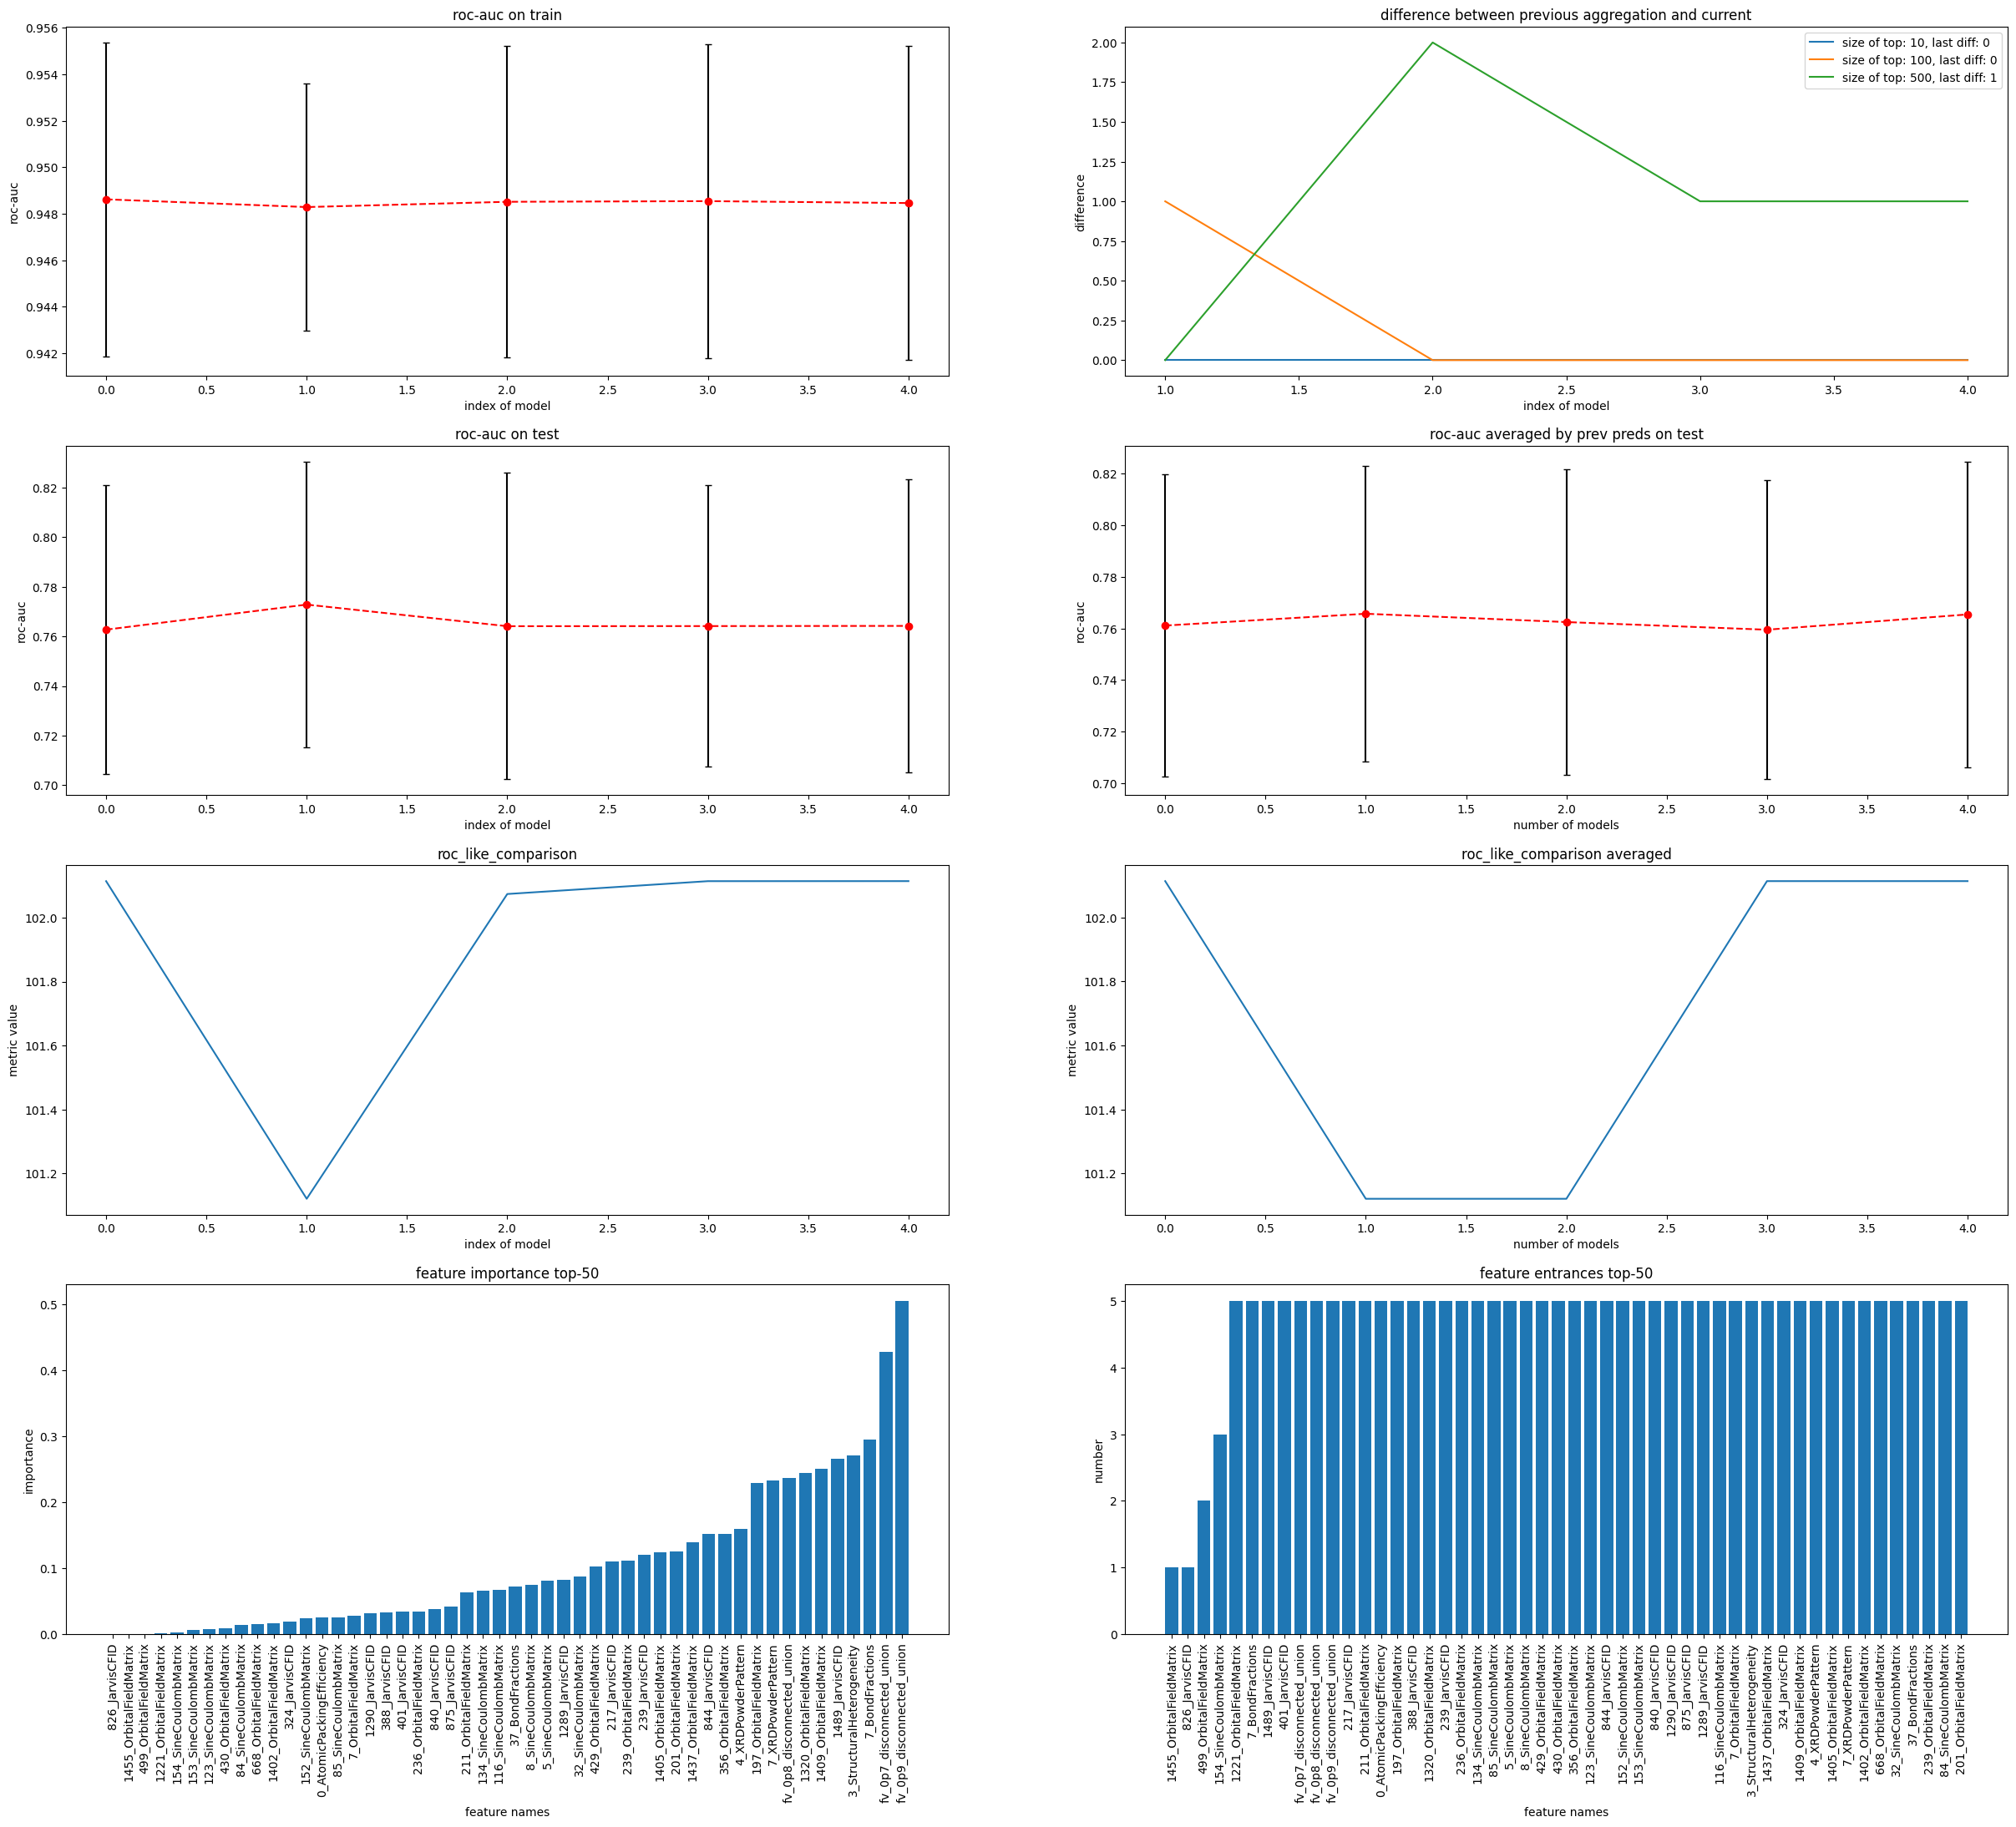

In [13]:
pipeline_logreg_l1_liblinear.plot_statistics()

In [14]:
preds_logreg_l1_liblinear_kahle = pipeline_logreg_l1_liblinear.preds_kahle_averaged[-1]
preds_logreg_l1_liblinear_mpdb = pipeline_logreg_l1_liblinear.preds_mpdb_averaged[-1]
preds_logreg_l1_liblinear_exp = pipeline_logreg_l1_liblinear.preds_exp_averaged[-1]

In [15]:
np.save('predictions_regression_cv/merged_logreg_l1_liblinear_kahle.npy', preds_logreg_l1_liblinear_kahle)
np.save('predictions_regression_cv/merged_logreg_l1_liblinear_mpdb.npy', preds_logreg_l1_liblinear_mpdb)
np.save('predictions_regression_cv/merged_logreg_l1_liblinear_exp.npy', preds_logreg_l1_liblinear_exp)


In [17]:
params = {
    'penalty': 'l1',
    'cv': 3, 
    'scoring': 'roc_auc',
    "solver": "saga",
}

pipeline_logreg_l1_saga = ModelEvaluation(df_kahle_fin, preds_Kahle2020, model_name = 'logreg', params = params)    
pipeline_logreg_l1_saga.fit(X_kahle_merged, np.ones(X_kahle_merged.shape[1]), thr_positive = 1e-1, thr_negative = 1e-2, threshold = 1e-2, feature_names = feature_names_merged)
pipeline_logreg_l1_saga.evaluate_with_cv(num_of_evaluations = 5, X_mpdb = X_mpdb_merged, X_exp = X_exp_merged)
pipeline_logreg_l1_saga.get_aggregated_statistics()


  0%|          | 0/5 [00:00<?, ?it/s]

roc-auc on train for 0 fold with size 118: 0.9071729957805907
test roc-auc mean: 0.7751515029284582, std: 0.05491580291743597
mean train roc-auc: 0.9080184331135565


  0%|          | 0/1000 [00:00<?, ?it/s]

 20%|██        | 1/5 [14:21<57:27, 861.82s/it]

  0%|          | 0/1000 [00:00<?, ?it/s]

 40%|████      | 2/5 [28:43<43:04, 861.48s/it]

  0%|          | 0/1000 [00:00<?, ?it/s]

 60%|██████    | 3/5 [43:04<28:42, 861.46s/it]

  0%|          | 0/1000 [00:00<?, ?it/s]

 80%|████████  | 4/5 [57:23<14:20, 860.64s/it]

  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 5/5 [1:11:48<00:00, 861.70s/it]


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

In [18]:
pipeline_logreg_l1_saga.show_results()

,statistic,result
0,mean train roc-auc averaged by 40 models,0.908088
1,roc_auc on test by aggregated preds,0.774810
2,mean test roc-auc averaged by 40 models,0.772971
3,roc_like_comparison by aggregated preds,82.504947
4,roc_like_comparison averaged by 40 models,82.799961
5,roc_like_comparison std,0.479319


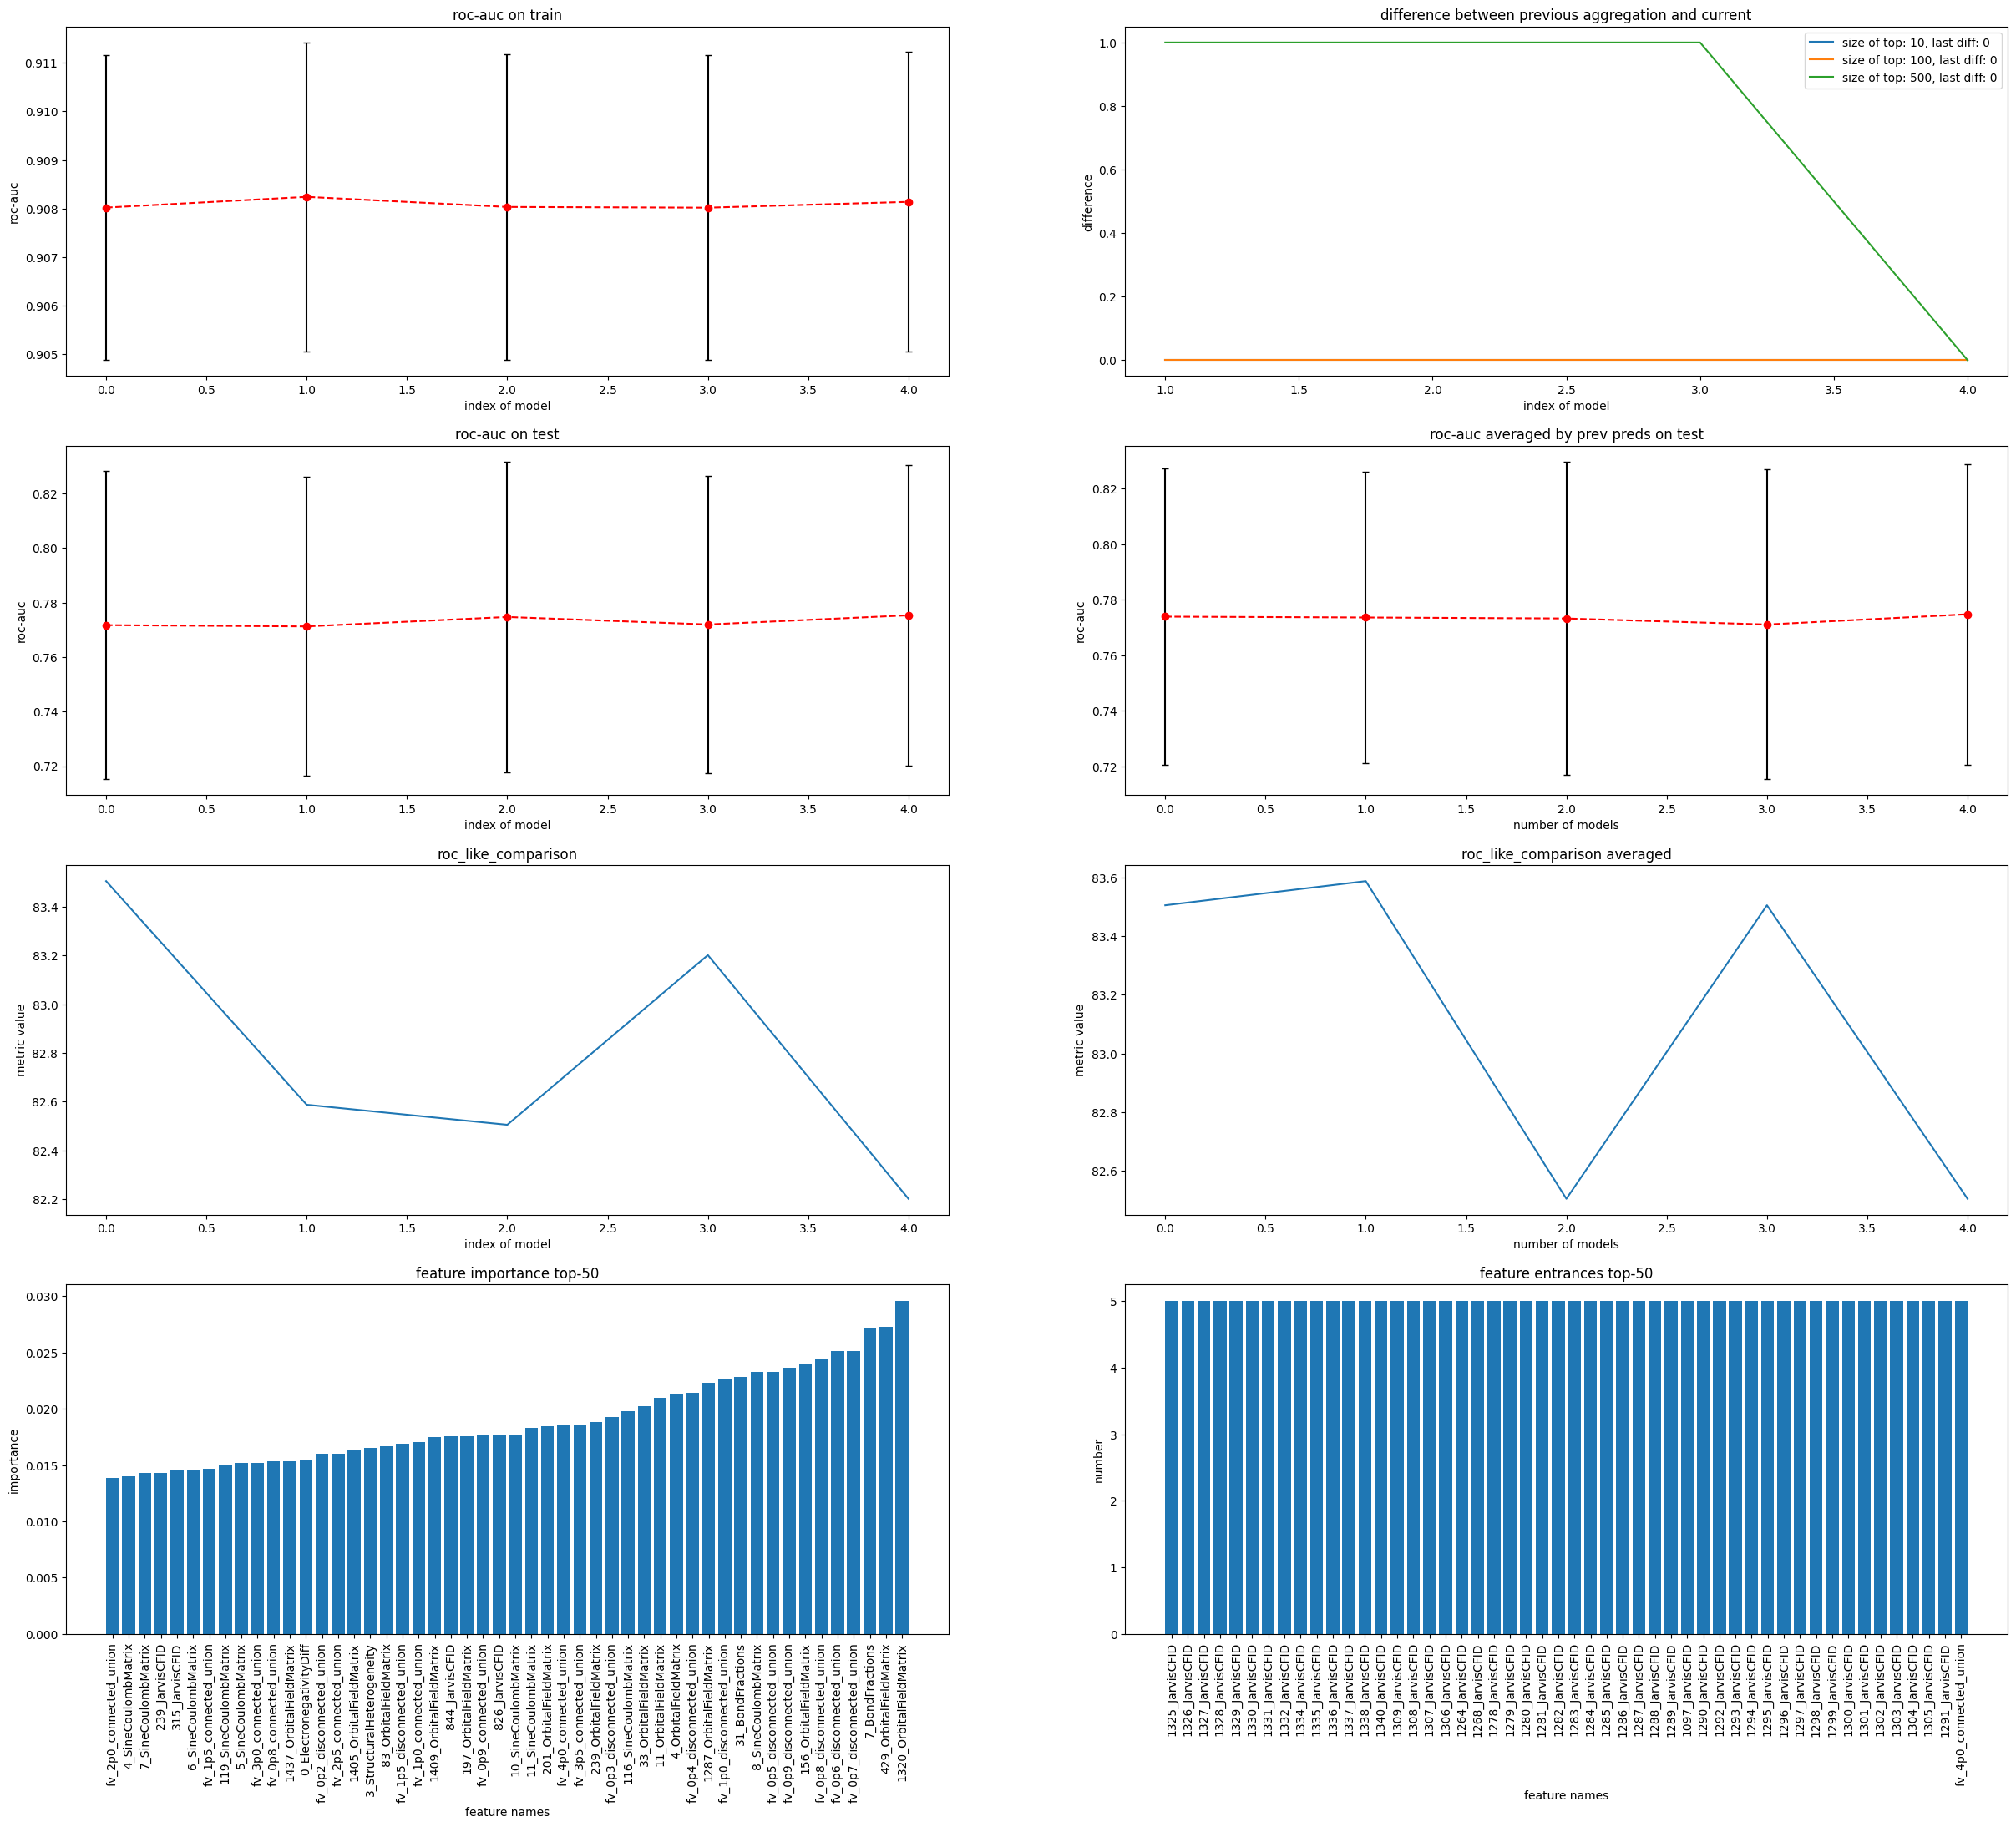

In [19]:
pipeline_logreg_l1_saga.plot_statistics()

In [20]:
preds_logreg_l1_saga_kahle = pipeline_logreg_l1_saga.preds_kahle_averaged[-1]
preds_logreg_l1_saga_mpdb = pipeline_logreg_l1_saga.preds_mpdb_averaged[-1]
preds_logreg_l1_saga_exp = pipeline_logreg_l1_saga.preds_exp_averaged[-1]

In [21]:
np.save('predictions_regression_cv/merged_logreg_l1_saga_kahle.npy', preds_logreg_l1_saga_kahle)
np.save('predictions_regression_cv/merged_logreg_l1_saga_mpdb.npy', preds_logreg_l1_saga_mpdb)
np.save('predictions_regression_cv/merged_logreg_l1_saga_exp.npy', preds_logreg_l1_saga_exp)


In [22]:
params = {
    'penalty': 'l2',
    'cv': 3, 
    'scoring': 'roc_auc',
    "solver": "liblinear",
}

pipeline_logreg_l2_liblinear = ModelEvaluation(df_kahle_fin, preds_Kahle2020, model_name = 'logreg', params = params)    
pipeline_logreg_l2_liblinear.fit(X_kahle_merged, np.ones(X_kahle_merged.shape[1]), thr_positive = 1e-1, thr_negative = 1e-2, threshold = 1e-2, feature_names = feature_names_merged)
pipeline_logreg_l2_liblinear.evaluate_with_cv(num_of_evaluations = 5, X_mpdb = X_mpdb_merged, X_exp = X_exp_merged)
pipeline_logreg_l2_liblinear.get_aggregated_statistics()


  0%|          | 0/5 [00:00<?, ?it/s]

roc-auc on train for 0 fold with size 118: 0.8446932814021422
test roc-auc mean: 0.7065816970906792, std: 0.06382807000054559
mean train roc-auc: 0.8765428407108199


  0%|          | 0/1000 [00:00<?, ?it/s]

 20%|██        | 1/5 [03:01<12:06, 181.70s/it]

  0%|          | 0/1000 [00:00<?, ?it/s]

 40%|████      | 2/5 [06:03<09:04, 181.50s/it]

  0%|          | 0/1000 [00:00<?, ?it/s]

 60%|██████    | 3/5 [09:05<06:03, 181.73s/it]

  0%|          | 0/1000 [00:00<?, ?it/s]

 80%|████████  | 4/5 [12:07<03:01, 181.86s/it]

  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 5/5 [15:08<00:00, 181.74s/it]


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

In [23]:
pipeline_logreg_l2_liblinear.show_results()

,statistic,result
0,mean train roc-auc averaged by 40 models,0.876543
1,roc_auc on test by aggregated preds,0.708907
2,mean test roc-auc averaged by 40 models,0.705557
3,roc_like_comparison by aggregated preds,75.341437
4,roc_like_comparison averaged by 40 models,75.341437
5,roc_like_comparison std,0.000000


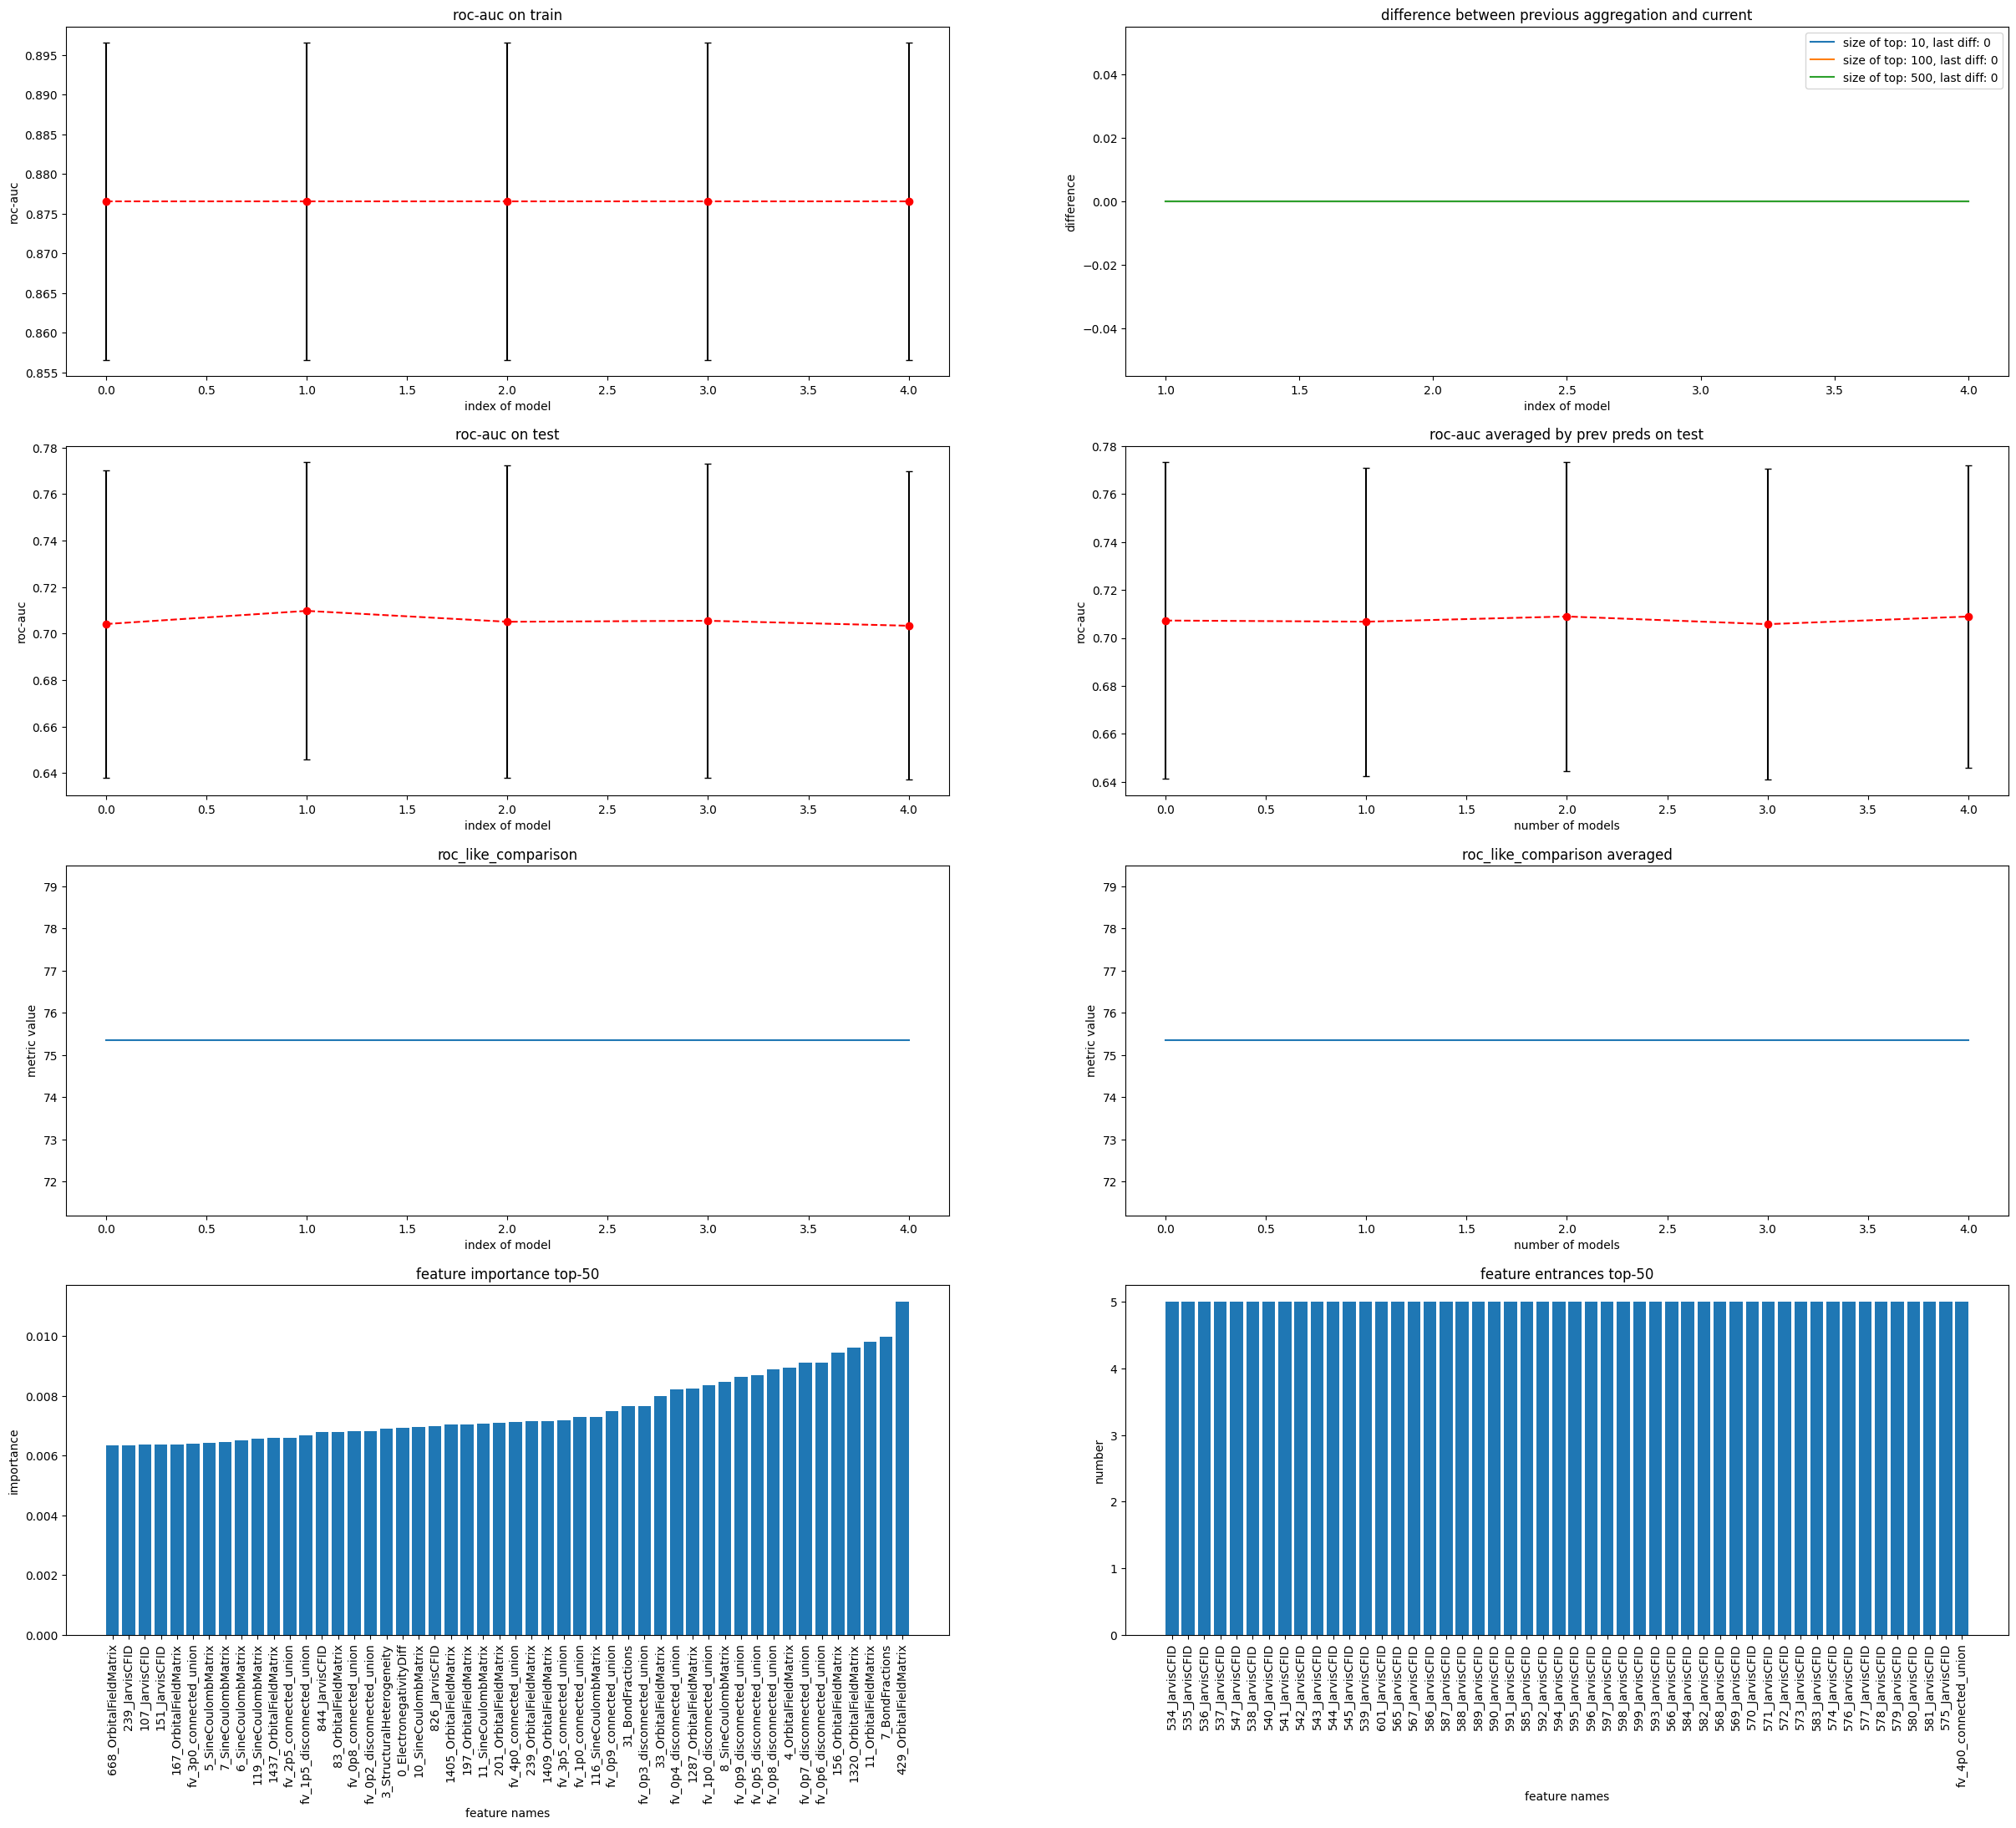

In [24]:
pipeline_logreg_l2_liblinear.plot_statistics()

In [25]:
preds_logreg_l2_liblinear_kahle = pipeline_logreg_l2_liblinear.preds_kahle_averaged[-1]
preds_logreg_l2_liblinear_mpdb = pipeline_logreg_l2_liblinear.preds_mpdb_averaged[-1]
preds_logreg_l2_liblinear_exp = pipeline_logreg_l2_liblinear.preds_exp_averaged[-1]

In [26]:
np.save('predictions_regression_cv/merged_logreg_l2_liblinear_kahle.npy', preds_logreg_l2_liblinear_kahle)
np.save('predictions_regression_cv/merged_logreg_l2_liblinear_mpdb.npy', preds_logreg_l2_liblinear_mpdb)
np.save('predictions_regression_cv/merged_logreg_l2_liblinear_exp.npy', preds_logreg_l2_liblinear_exp)


In [28]:
params = {
    'penalty': 'l2',
    'cv': 3, 
    'scoring': 'roc_auc',
    "solver": "saga",
}
 
pipeline_logreg_l2_saga = ModelEvaluation(df_kahle_fin, preds_Kahle2020, model_name = 'logreg', params = params)    
pipeline_logreg_l2_saga.fit(X_kahle_merged, np.ones(X_kahle_merged.shape[1]), thr_positive = 1e-1, thr_negative = 1e-2, threshold = 1e-2, feature_names = feature_names_merged)
pipeline_logreg_l2_saga.evaluate_with_cv(num_of_evaluations = 2, X_mpdb = X_mpdb_merged, X_exp = X_exp_merged)
pipeline_logreg_l2_saga.get_aggregated_statistics()


  0%|          | 0/2 [00:00<?, ?it/s]

roc-auc on train for 0 fold with size 118: 0.8448555663745537
test roc-auc mean: 0.6883190727371248, std: 0.06713120419618407
mean train roc-auc: 0.877452865750861


  0%|          | 0/1000 [00:00<?, ?it/s]

 50%|█████     | 1/2 [13:45<13:45, 825.74s/it]

  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 2/2 [27:31<00:00, 825.90s/it]


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

In [29]:
pipeline_logreg_l2_saga.show_results()

,statistic,result
0,mean train roc-auc averaged by 40 models,0.877475
1,roc_auc on test by aggregated preds,0.686556
2,mean test roc-auc averaged by 40 models,0.687474
3,roc_like_comparison by aggregated preds,84.275168
4,roc_like_comparison averaged by 40 models,84.275168
5,roc_like_comparison std,0.000000


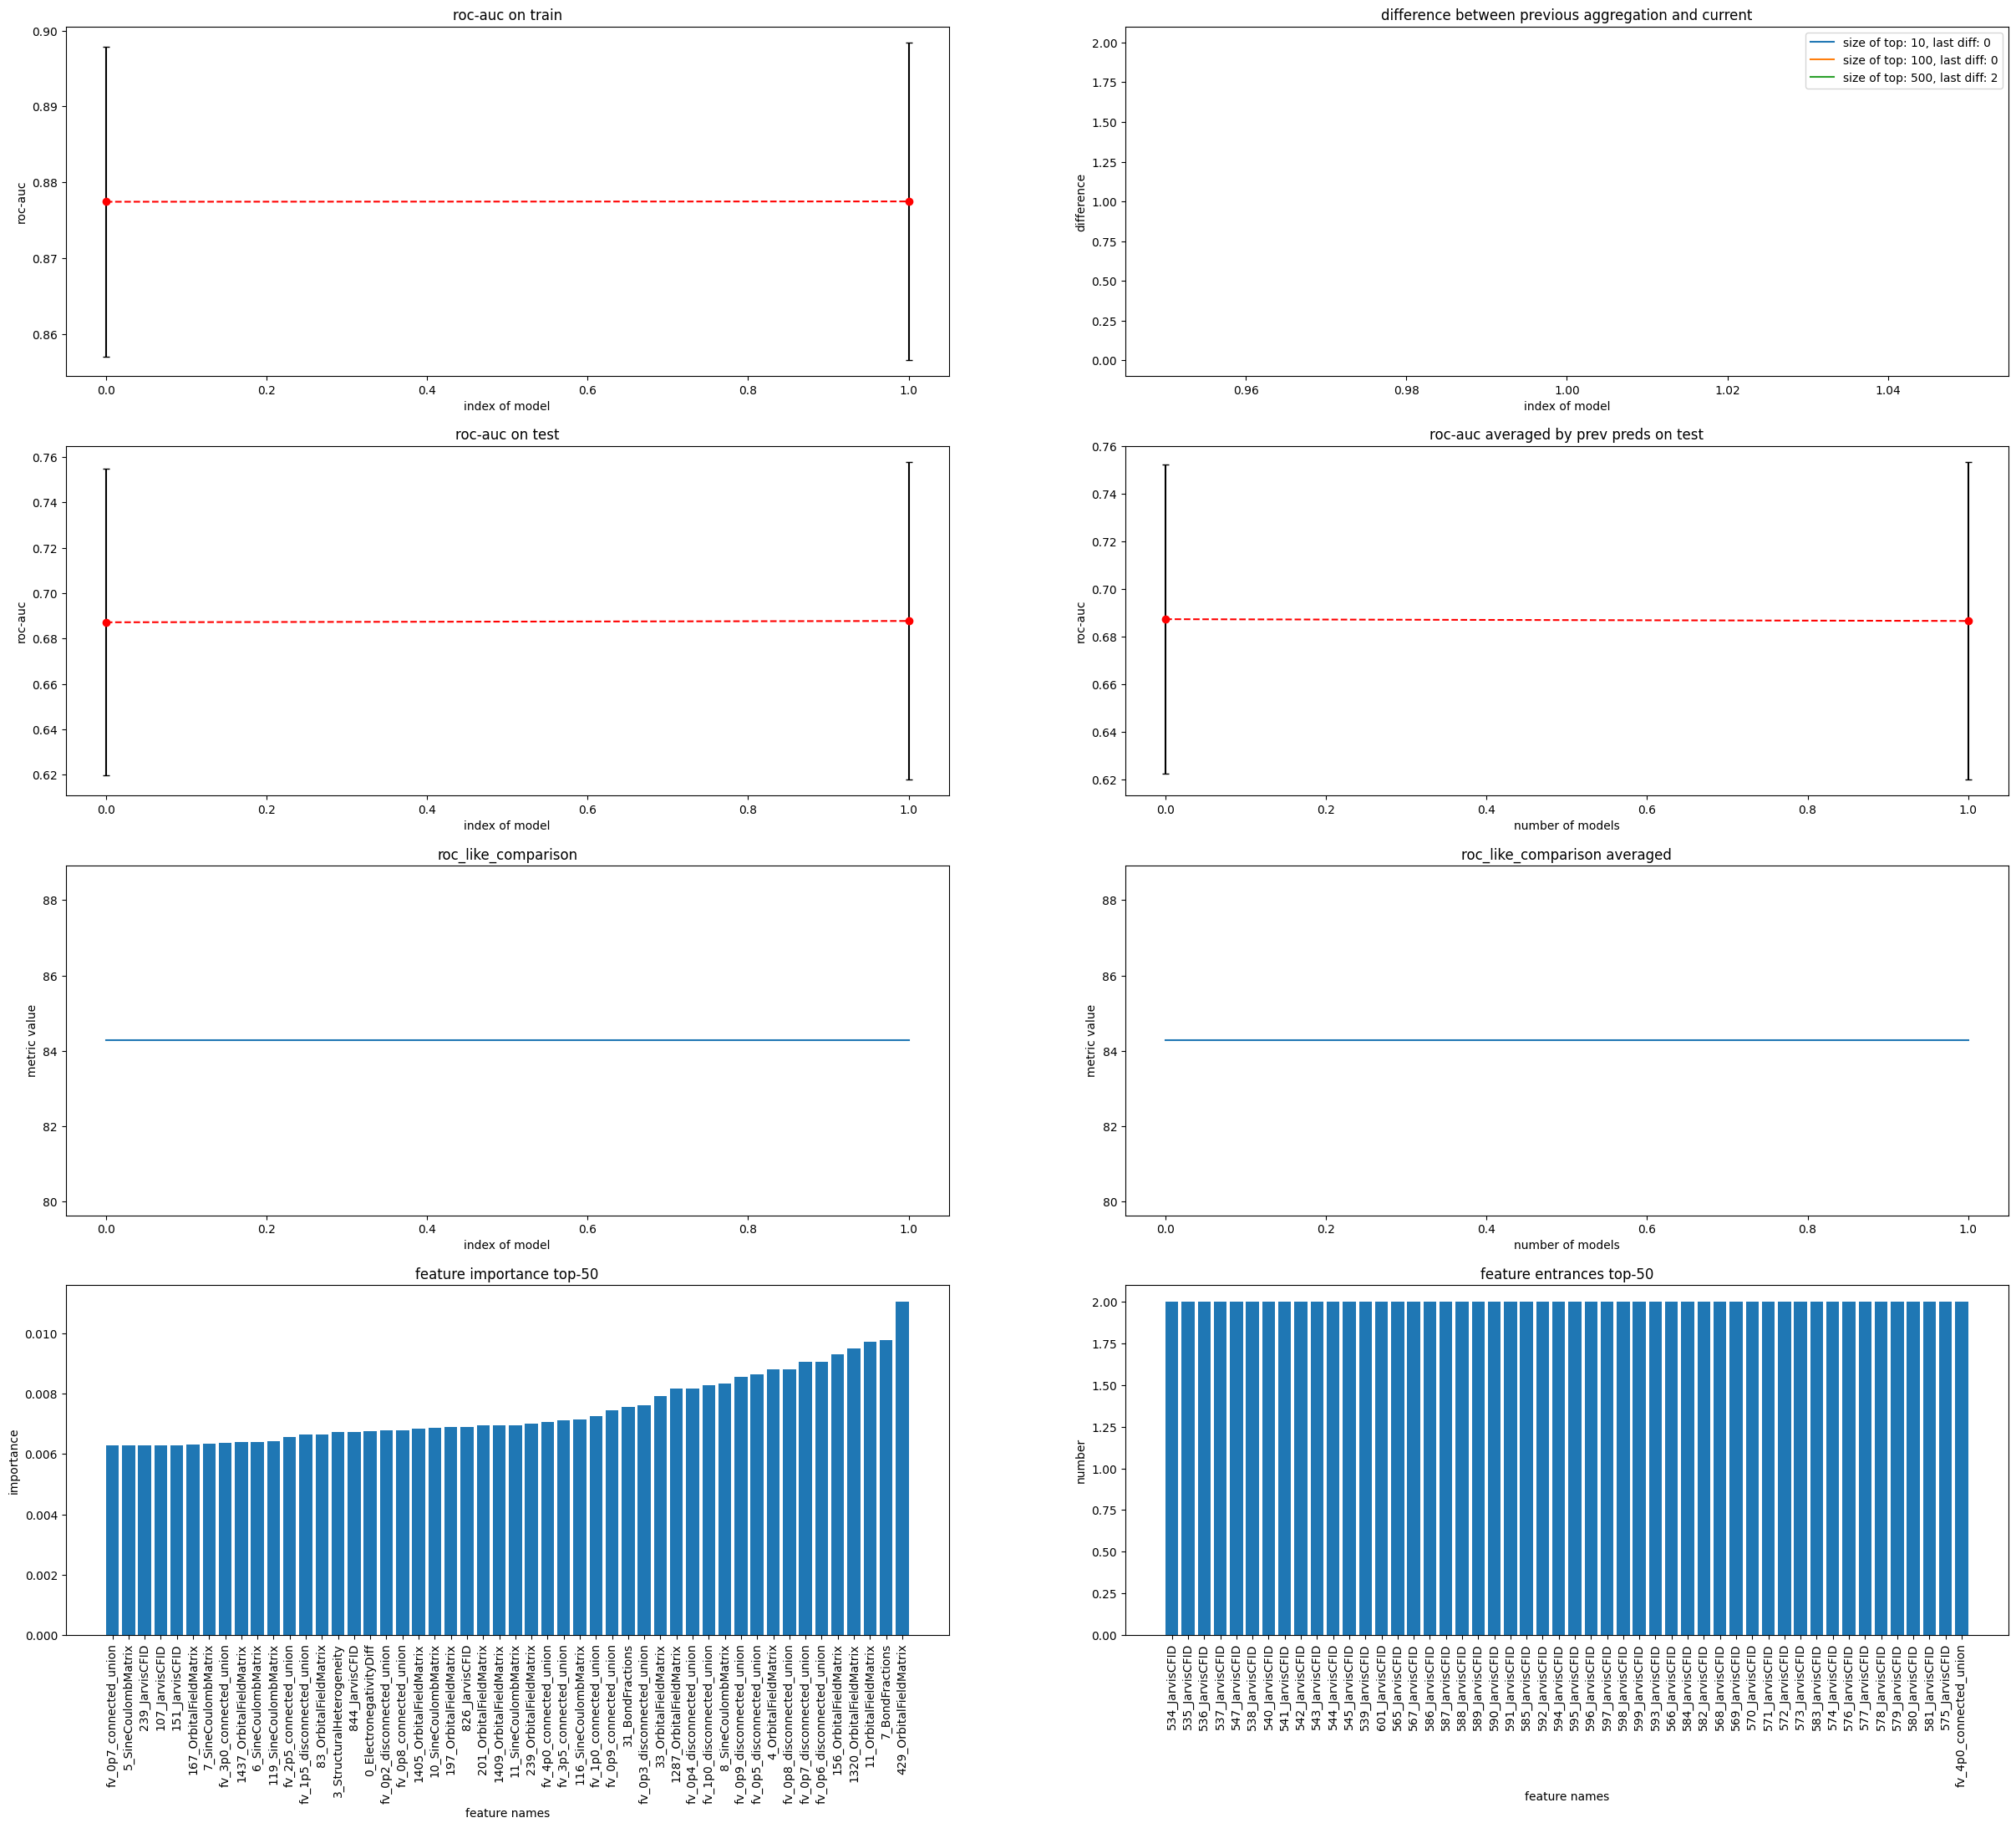

In [30]:
pipeline_logreg_l2_saga.plot_statistics()

In [31]:
np.save('predictions_regression_cv/merged_logreg_l2_saga_kahle.npy', preds_logreg_l2_liblinear_kahle)
np.save('predictions_regression_cv/merged_logreg_l2_saga_mpdb.npy', preds_logreg_l2_liblinear_mpdb)
np.save('predictions_regression_cv/merged_logreg_l2_saga_exp.npy', preds_logreg_l2_liblinear_exp)
